In [1]:
import time
import functools
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def mrp2ep(m):
    m_mag = np.dot(m, m.T)
    return np.array([(1 - m_mag) / (1 + m_mag)] + [(2 * m_i) / (1 + m_mag) for m_i in m])

def quat2dcm(q):
    q0, q1, q2, q3 = q
    return np.array((
        (q0**2+q1**2-q2**2-q3**2, 2*(q1*q2+q0*q3), 2*(q1*q3-q0*q2)),
        (2*(q1*q2-q0*q3), q0**2-q1**2+q2**2-q3**2, 2*(q2*q3+q0*q1)),
        (2*(q1*q3+q0*q2), 2*(q2*q3-q0*q1), q0**2-q1**2-q2**2+q3**2)
    ))

def AU2m(x):
    return x * 149597870691

def quaternion_conjugate(q):
    ret = np.copy(q)
    ret[:, 1:] *= -1
    return ret

def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1[:, 0], q1[:, 1], q1[:, 2], q1[:, 3]
    w2, x2, y2, z2 = q2[:, 0], q2[:, 1], q2[:, 2], q2[:, 3]
    result = np.empty_like(q1)
    result[:, 0] = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    result[:, 1] = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    result[:, 2] = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    result[:, 3] = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
    return result

def quaternion_to_angle(q):
    theta = 2 * np.arccos(q[:, 0])
    return np.degrees(theta)

def attitude_error(q, q_ref):
    q_ref_conj = quaternion_conjugate(q_ref)
    q_rel = quaternion_multiply(q, q_ref_conj)
    q_rel /= np.linalg.norm(q_rel, axis=1, keepdims=True)
    return quaternion_to_angle(q_rel)

In [3]:
# Load state data from sim.
rootdir = "../ads/data/"
time_s = np.load(rootdir + "time_s.npy")                     # Simulation time (s).
sigma_bn_mrp = np.load(rootdir + "sigma_bn_mrp.npy")         # Attitude MRP in inertial frame.
mrp_switches = np.load(rootdir + "mrp_switches.npy")         # Accumulated MRP switches.
omega_bn_b = np.load(rootdir + "omega_bn_b.npy")             # Angular velocity of the spacecraft (rad/s).
r_bn_n = np.load(rootdir + "r_bn_n.npy")                     # Position of the s/c relative to Earth (m).
css_meas = np.load(rootdir + "css.npy")                      # Coarse Sun Sensor (CSS) data.
sun_vectors_inertial = np.load(rootdir + "sun.npy")          # Position of the Sun relative to Earth (m).
tam_meas = np.load(rootdir + "tam.npy")                      # Three-axis Magnetometer (TAM) data.
mag_fields_earth_fixed = np.load(rootdir + "mag_field.npy")  # Local magnetic field (T).

# Convert attitude data from MRP to EP (can't forget to account for MRP switching).
q_bn = np.apply_along_axis(mrp2ep, axis=1, arr=sigma_bn_mrp)
q_bn[np.where(mrp_switches % 2)[0]] = q_bn[np.where(mrp_switches % 2)[0]] * -1

# Normalize mag field model and measurements (CSS already normalized).
normalize = lambda v: v / np.linalg.norm(v)
tam_meas = np.apply_along_axis(normalize, axis=1, arr=tam_meas)
mag_fields_earth_fixed = np.apply_along_axis(normalize, axis=1, arr=mag_fields_earth_fixed)

# Orientations of the coarse sun sensors.
css_vectors = np.array((
    ( 1,  0,  0), (-1,  0,  0),  # +/- X
    ( 0,  1,  0), ( 0, -1,  0),  # +/- Y
    ( 0,  0,  1), ( 0,  0, -1),  # +/- Z
))

# Spacecraft moments of inertia.
moi = np.array((
    (900., 0., 0.),  # X
    (0., 800., 0.),  # Y
    (0., 0., 600.),  # Z
))

# Stack attitude and angular rates to form ground truth 7d state history.
state_gt = np.hstack((q_bn, omega_bn_b))

# Stack CSS and TAM measurements to form 9d measurements history.
meas = np.hstack((css_meas, tam_meas))

# Control inputs - empty for now.
controls = np.zeros_like(time_s)

In [4]:
# Load state data from sim.
rootdir = "data/srp/"
srp_time_s = np.load(rootdir + "time_s.npy")                     # Simulation time (s).
srp_sigma_bn_mrp = np.load(rootdir + "sigma_bn_mrp.npy")         # Attitude MRP in inertial frame.
srp_mrp_switches = np.load(rootdir + "mrp_switches.npy")         # Accumulated MRP switches.
srp_omega_bn_b = np.load(rootdir + "omega_bn_b.npy")             # Angular velocity of the spacecraft (rad/s).
srp_r_bn_n = np.load(rootdir + "r_bn_n.npy")                     # Position of the s/c relative to Earth (m).
srp_css_meas = np.load(rootdir + "css.npy")                      # Coarse Sun Sensor (CSS) data.
srp_sun_vectors_inertial = np.load(rootdir + "sun.npy")          # Position of the Sun relative to Earth (m).
srp_tam_meas = np.load(rootdir + "tam.npy")                      # Three-axis Magnetometer (TAM) data.
srp_mag_fields_earth_fixed = np.load(rootdir + "mag_field.npy")  # Local magnetic field (T).

# Convert attitude data from MRP to EP (can't forget to account for MRP switching).
srp_q_bn = np.apply_along_axis(mrp2ep, axis=1, arr=srp_sigma_bn_mrp)
srp_q_bn[np.where(srp_mrp_switches % 2)[0]] = srp_q_bn[np.where(srp_mrp_switches % 2)[0]] * -1

# Normalize mag field model and measurements (CSS already normalized).
normalize = lambda v: v / np.linalg.norm(v)
srp_tam_meas = np.apply_along_axis(normalize, axis=1, arr=srp_tam_meas)
srp_mag_fields_earth_fixed = np.apply_along_axis(normalize, axis=1, arr=srp_mag_fields_earth_fixed)

# Orientations of the coarse sun sensors.
css_vectors = np.array((
    ( 1,  0,  0), (-1,  0,  0),  # +/- X
    ( 0,  1,  0), ( 0, -1,  0),  # +/- Y
    ( 0,  0,  1), ( 0,  0, -1),  # +/- Z
))

# Spacecraft moments of inertia.
moi = np.array((
    (900., 0., 0.),  # X
    (0., 800., 0.),  # Y
    (0., 0., 600.),  # Z
))

# Stack attitude and angular rates to form ground truth 7d state history.
srp_state_gt = np.hstack((srp_q_bn, srp_omega_bn_b))

# Stack CSS and TAM measurements to form 9d measurements history.
srp_meas = np.hstack((srp_css_meas, srp_tam_meas))

# Control inputs - empty for now.
srp_controls = np.zeros_like(srp_time_s)

In [5]:
print("time_s:                ", np.allclose(time_s, srp_time_s))
print("sigma_bn_mrp:          ", np.allclose(sigma_bn_mrp, srp_sigma_bn_mrp))
print("mrp_switches:          ", np.allclose(mrp_switches, srp_mrp_switches))
print("omega_bn_b:            ", np.allclose(omega_bn_b, srp_omega_bn_b))
print("r_bn_n:                ", np.allclose(r_bn_n, srp_r_bn_n))
print("css_meas:              ", np.allclose(css_meas, srp_css_meas))
print("sun_vectors_inertial:  ", np.allclose(sun_vectors_inertial, srp_sun_vectors_inertial))
print("tam_meas:              ", np.allclose(tam_meas, srp_tam_meas))
print("mag_fields_earth_fixed:", np.allclose(mag_fields_earth_fixed, srp_mag_fields_earth_fixed))

time_s:                 True
sigma_bn_mrp:           False
mrp_switches:           True
omega_bn_b:             False
r_bn_n:                 False
css_meas:               False
sun_vectors_inertial:   True
tam_meas:               False
mag_fields_earth_fixed: False


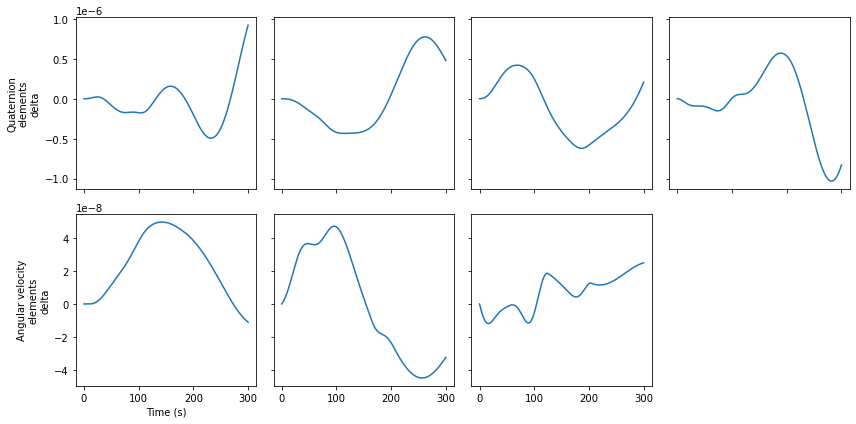

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey="row")
axs[0, 0].plot(time_s, q_bn[:, 0] - srp_q_bn[:, 0])
axs[0, 1].plot(time_s, q_bn[:, 1] - srp_q_bn[:, 1])
axs[0, 2].plot(time_s, q_bn[:, 2] - srp_q_bn[:, 2])
axs[0, 3].plot(time_s, q_bn[:, 3] - srp_q_bn[:, 3])
axs[1, 0].plot(time_s, omega_bn_b[:, 0] - srp_omega_bn_b[:, 0])
axs[1, 1].plot(time_s, omega_bn_b[:, 1] - srp_omega_bn_b[:, 1])
axs[1, 2].plot(time_s, omega_bn_b[:, 2] - srp_omega_bn_b[:, 2])
fig.delaxes(axs[1, 3])
axs[0, 0].set_ylabel("Quaternion\nelements\ndelta")
axs[1, 0].set_ylabel("Angular velocity\nelements\ndelta")
axs[1, 0].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [7]:
# Load state data from sim.
rootdir = "data/drag/"
drag_time_s = np.load(rootdir + "time_s.npy")                     # Simulation time (s).
drag_sigma_bn_mrp = np.load(rootdir + "sigma_bn_mrp.npy")         # Attitude MRP in inertial frame.
drag_mrp_switches = np.load(rootdir + "mrp_switches.npy")         # Accumulated MRP switches.
drag_omega_bn_b = np.load(rootdir + "omega_bn_b.npy")             # Angular velocity of the spacecraft (rad/s).
drag_r_bn_n = np.load(rootdir + "r_bn_n.npy")                     # Position of the s/c relative to Earth (m).
drag_css_meas = np.load(rootdir + "css.npy")                      # Coarse Sun Sensor (CSS) data.
drag_sun_vectors_inertial = np.load(rootdir + "sun.npy")          # Position of the Sun relative to Earth (m).
drag_tam_meas = np.load(rootdir + "tam.npy")                      # Three-axis Magnetometer (TAM) data.
drag_mag_fields_earth_fixed = np.load(rootdir + "mag_field.npy")  # Local magnetic field (T).

# Convert attitude data from MRP to EP (can't forget to account for MRP switching).
drag_q_bn = np.apply_along_axis(mrp2ep, axis=1, arr=drag_sigma_bn_mrp)
drag_q_bn[np.where(drag_mrp_switches % 2)[0]] = drag_q_bn[np.where(drag_mrp_switches % 2)[0]] * -1

# Normalize mag field model and measurements (CSS already normalized).
normalize = lambda v: v / np.linalg.norm(v)
drag_tam_meas = np.apply_along_axis(normalize, axis=1, arr=drag_tam_meas)
drag_mag_fields_earth_fixed = np.apply_along_axis(normalize, axis=1, arr=drag_mag_fields_earth_fixed)

# Orientations of the coarse sun sensors.
css_vectors = np.array((
    ( 1,  0,  0), (-1,  0,  0),  # +/- X
    ( 0,  1,  0), ( 0, -1,  0),  # +/- Y
    ( 0,  0,  1), ( 0,  0, -1),  # +/- Z
))

# Spacecraft moments of inertia.
moi = np.array((
    (900., 0., 0.),  # X
    (0., 800., 0.),  # Y
    (0., 0., 600.),  # Z
))

# Stack attitude and angular rates to form ground truth 7d state history.
drag_state_gt = np.hstack((drag_q_bn, drag_omega_bn_b))

# Stack CSS and TAM measurements to form 9d measurements history.
drag_meas = np.hstack((drag_css_meas, drag_tam_meas))

# Control inputs - empty for now.
drag_controls = np.zeros_like(drag_time_s)

In [8]:
print("time_s:                ", np.allclose(time_s, drag_time_s))
print("sigma_bn_mrp:          ", np.allclose(sigma_bn_mrp, drag_sigma_bn_mrp))
print("mrp_switches:          ", np.allclose(mrp_switches, drag_mrp_switches))
print("omega_bn_b:            ", np.allclose(omega_bn_b, drag_omega_bn_b))
print("r_bn_n:                ", np.allclose(r_bn_n, drag_r_bn_n))
print("css_meas:              ", np.allclose(css_meas, drag_css_meas))
print("sun_vectors_inertial:  ", np.allclose(sun_vectors_inertial, drag_sun_vectors_inertial))
print("tam_meas:              ", np.allclose(tam_meas, drag_tam_meas))
print("mag_fields_earth_fixed:", np.allclose(mag_fields_earth_fixed, drag_mag_fields_earth_fixed))

time_s:                 True
sigma_bn_mrp:           True
mrp_switches:           True
omega_bn_b:             True
r_bn_n:                 False
css_meas:               False
sun_vectors_inertial:   True
tam_meas:               False
mag_fields_earth_fixed: False


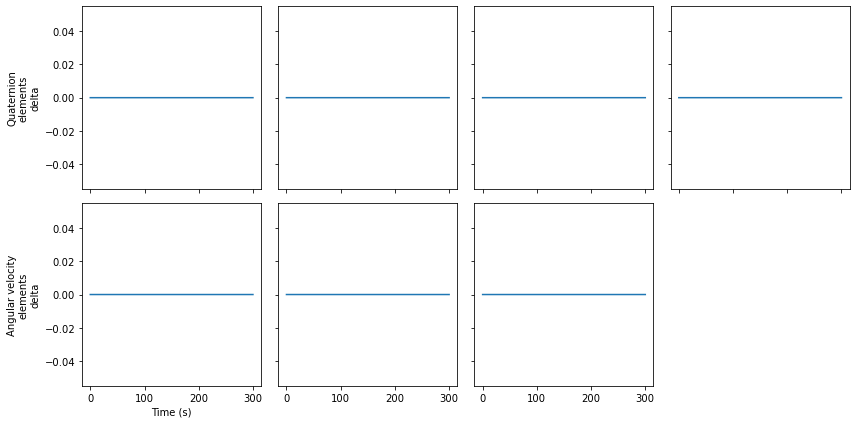

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey="row")
axs[0, 0].plot(time_s, q_bn[:, 0] - drag_q_bn[:, 0])
axs[0, 1].plot(time_s, q_bn[:, 1] - drag_q_bn[:, 1])
axs[0, 2].plot(time_s, q_bn[:, 2] - drag_q_bn[:, 2])
axs[0, 3].plot(time_s, q_bn[:, 3] - drag_q_bn[:, 3])
axs[1, 0].plot(time_s, omega_bn_b[:, 0] - drag_omega_bn_b[:, 0])
axs[1, 1].plot(time_s, omega_bn_b[:, 1] - drag_omega_bn_b[:, 1])
axs[1, 2].plot(time_s, omega_bn_b[:, 2] - drag_omega_bn_b[:, 2])
fig.delaxes(axs[1, 3])
axs[0, 0].set_ylabel("Quaternion\nelements\ndelta")
axs[1, 0].set_ylabel("Angular velocity\nelements\ndelta")
axs[1, 0].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [11]:
# Load state data from sim.
rootdir = "../ads/data/low/"
low_time_s = np.load(rootdir + "time_s.npy")                     # Simulation time (s).
low_sigma_bn_mrp = np.load(rootdir + "sigma_bn_mrp.npy")         # Attitude MRP in inertial frame.
low_mrp_switches = np.load(rootdir + "mrp_switches.npy")         # Accumulated MRP switches.
low_omega_bn_b = np.load(rootdir + "omega_bn_b.npy")             # Angular velocity of the spacecraft (rad/s).
low_r_bn_n = np.load(rootdir + "r_bn_n.npy")                     # Position of the s/c relative to Earth (m).
low_css_meas = np.load(rootdir + "css.npy")                      # Coarse Sun Sensor (CSS) data.
low_sun_vectors_inertial = np.load(rootdir + "sun.npy")          # Position of the Sun relative to Earth (m).
low_tam_meas = np.load(rootdir + "tam.npy")                      # Three-axis Magnetometer (TAM) data.
low_mag_fields_earth_fixed = np.load(rootdir + "mag_field.npy")  # Local magnetic field (T).

# Convert attitude data from MRP to EP (can't forget to account for MRP switching).
low_q_bn = np.apply_along_axis(mrp2ep, axis=1, arr=low_sigma_bn_mrp)
low_q_bn[np.where(low_mrp_switches % 2)[0]] = low_q_bn[np.where(low_mrp_switches % 2)[0]] * -1

# Normalize mag field model and measurements (CSS already normalized).
normalize = lambda v: v / np.linalg.norm(v)
low_tam_meas = np.apply_along_axis(normalize, axis=1, arr=low_tam_meas)
low_mag_fields_earth_fixed = np.apply_along_axis(normalize, axis=1, arr=low_mag_fields_earth_fixed)

# Orientations of the coarse sun sensors.
css_vectors = np.array((
    ( 1,  0,  0), (-1,  0,  0),  # +/- X
    ( 0,  1,  0), ( 0, -1,  0),  # +/- Y
    ( 0,  0,  1), ( 0,  0, -1),  # +/- Z
))

# Spacecraft moments of inertia.
moi = np.array((
    (900., 0., 0.),  # X
    (0., 800., 0.),  # Y
    (0., 0., 600.),  # Z
))

# Stack attitude and angular rates to form ground truth 7d state history.
low_state_gt = np.hstack((low_q_bn, low_omega_bn_b))

# Stack CSS and TAM measurements to form 9d measurements history.
low_meas = np.hstack((low_css_meas, low_tam_meas))

# Control inputs - empty for now.
low_controls = np.zeros_like(low_time_s)

In [12]:
# Load state data from sim.
rootdir = "data/drag/low/"
drag_low_time_s = np.load(rootdir + "time_s.npy")                     # Simulation time (s).
drag_low_sigma_bn_mrp = np.load(rootdir + "sigma_bn_mrp.npy")         # Attitude MRP in inertial frame.
drag_low_mrp_switches = np.load(rootdir + "mrp_switches.npy")         # Accumulated MRP switches.
drag_low_omega_bn_b = np.load(rootdir + "omega_bn_b.npy")             # Angular velocity of the spacecraft (rad/s).
drag_low_r_bn_n = np.load(rootdir + "r_bn_n.npy")                     # Position of the s/c relative to Earth (m).
drag_low_css_meas = np.load(rootdir + "css.npy")                      # Coarse Sun Sensor (CSS) data.
drag_low_sun_vectors_inertial = np.load(rootdir + "sun.npy")          # Position of the Sun relative to Earth (m).
drag_low_tam_meas = np.load(rootdir + "tam.npy")                      # Three-axis Magnetometer (TAM) data.
drag_low_mag_fields_earth_fixed = np.load(rootdir + "mag_field.npy")  # Local magnetic field (T).

# Convert attitude data from MRP to EP (can't forget to account for MRP switching).
drag_low_q_bn = np.apply_along_axis(mrp2ep, axis=1, arr=drag_low_sigma_bn_mrp)
drag_low_q_bn[np.where(drag_low_mrp_switches % 2)[0]] = drag_low_q_bn[np.where(drag_low_mrp_switches % 2)[0]] * -1

# Normalize mag field model and measurements (CSS already normalized).
normalize = lambda v: v / np.linalg.norm(v)
drag_low_tam_meas = np.apply_along_axis(normalize, axis=1, arr=drag_low_tam_meas)
drag_low_mag_fields_earth_fixed = np.apply_along_axis(normalize, axis=1, arr=drag_low_mag_fields_earth_fixed)

# Orientations of the coarse sun sensors.
css_vectors = np.array((
    ( 1,  0,  0), (-1,  0,  0),  # +/- X
    ( 0,  1,  0), ( 0, -1,  0),  # +/- Y
    ( 0,  0,  1), ( 0,  0, -1),  # +/- Z
))

# Spacecraft moments of inertia.
moi = np.array((
    (900., 0., 0.),  # X
    (0., 800., 0.),  # Y
    (0., 0., 600.),  # Z
))

# Stack attitude and angular rates to form ground truth 7d state history.
drag_low_state_gt = np.hstack((drag_low_q_bn, drag_low_omega_bn_b))

# Stack CSS and TAM measurements to form 9d measurements history.
drag_low_meas = np.hstack((drag_low_css_meas, drag_low_tam_meas))

# Control inputs - empty for now.
drag_low_controls = np.zeros_like(drag_low_time_s)

In [13]:
print("time_s:                ", np.allclose(low_time_s, drag_low_time_s))
print("sigma_bn_mrp:          ", np.allclose(low_sigma_bn_mrp, drag_low_sigma_bn_mrp))
print("mrp_switches:          ", np.allclose(low_mrp_switches, drag_low_mrp_switches))
print("omega_bn_b:            ", np.allclose(low_omega_bn_b, drag_low_omega_bn_b))
print("r_bn_n:                ", np.allclose(low_r_bn_n, drag_low_r_bn_n))
print("css_meas:              ", np.allclose(low_css_meas, drag_low_css_meas))
print("sun_vectors_inertial:  ", np.allclose(low_sun_vectors_inertial, drag_low_sun_vectors_inertial))
print("tam_meas:              ", np.allclose(low_tam_meas, drag_low_tam_meas))
print("mag_fields_earth_fixed:", np.allclose(low_mag_fields_earth_fixed, drag_low_mag_fields_earth_fixed))

time_s:                 True
sigma_bn_mrp:           True
mrp_switches:           True
omega_bn_b:             True
r_bn_n:                 False
css_meas:               False
sun_vectors_inertial:   True
tam_meas:               False
mag_fields_earth_fixed: False


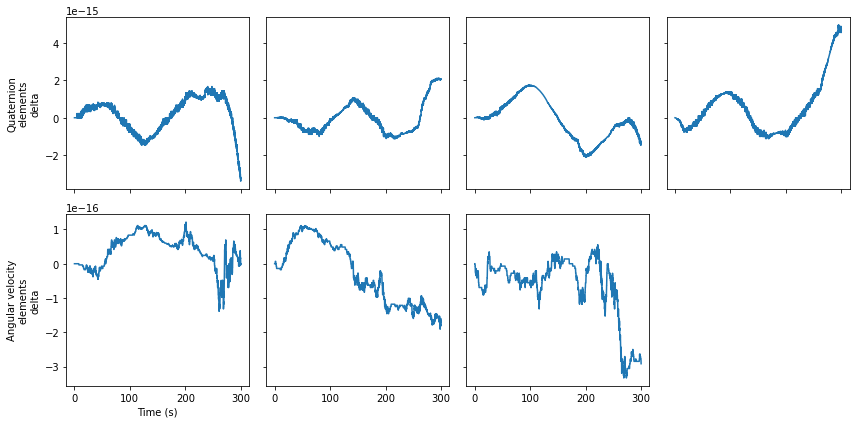

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey="row")
axs[0, 0].plot(low_time_s, low_q_bn[:, 0] - drag_low_q_bn[:, 0])
axs[0, 1].plot(low_time_s, low_q_bn[:, 1] - drag_low_q_bn[:, 1])
axs[0, 2].plot(low_time_s, low_q_bn[:, 2] - drag_low_q_bn[:, 2])
axs[0, 3].plot(low_time_s, low_q_bn[:, 3] - drag_low_q_bn[:, 3])
axs[1, 0].plot(low_time_s, low_omega_bn_b[:, 0] - drag_low_omega_bn_b[:, 0])
axs[1, 1].plot(low_time_s, low_omega_bn_b[:, 1] - drag_low_omega_bn_b[:, 1])
axs[1, 2].plot(low_time_s, low_omega_bn_b[:, 2] - drag_low_omega_bn_b[:, 2])
fig.delaxes(axs[1, 3])
axs[0, 0].set_ylabel("Quaternion\nelements\ndelta")
axs[1, 0].set_ylabel("Angular velocity\nelements\ndelta")
axs[1, 0].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [32]:
class AttitudeEstimatorEKF:
    
    def __init__(self, css_orientations, sc_moment_of_inertia):
        self.css_ors = css_orientations
        self.sc_moi = sc_moment_of_inertia
    
    @staticmethod
    def _W_matrix(w):
        wx, wy, wz = w
        return np.array((
            (0,  -wx, -wy, -wz),
            (wx,  0,   wz, -wy),
            (wy, -wz,  0,   wx),
            (wz,  wy, -wx,  0 )
        ))
    
    @staticmethod
    def numerical_jacobian(f, m, n, x, u=None, epsilon=1e-2):
        jacobian = np.zeros((m, n))
        perturb = np.eye(n) * epsilon
        for i in range(n):
            if u is None:
                jacobian[:, i] = (f(x + perturb[:, i]) - f(x - perturb[:, i])) / (2 * epsilon)
            else:
                jacobian[:, i] = (f(x + perturb[:, i], u) - f(x - perturb[:, i], u)) / (2 * epsilon)
        return jacobian

    def _process_model(self, x, dt, u):
        q, w = x[:4], x[4:]
        x_hat = np.zeros(7)

        # Quaternion dynamics.
        q_dot = 0.5 * self._W_matrix(w) @ q
        x_hat[:4] = q + q_dot * dt
        x_hat[:4] /= np.linalg.norm(x_hat[:4])

        # Angular velocity dynamics.
        w_dot = np.linalg.inv(self.sc_moi) @ (np.cross(-w, self.sc_moi @ w))
        x_hat[4:] = w + w_dot * dt

        return x_hat

    def _measurement_model(self, x, sc_position_inertial, sun_vector_inertial, mag_field_earth_fixed):
        q, w = x[:4], x[4:]
        
        h = np.zeros(9)
        
        body_dcm_est = quat2dcm(q)

        # CSS measurement model.        
        sun_vector_relative = sun_vector_inertial - sc_position_inertial
        sun_vector_body = (body_dcm_est @ sun_vector_relative) / np.linalg.norm(sun_vector_relative)
        sun_distance = np.linalg.norm(sun_vector_inertial)
        for i in range(6):
            # See https://hanspeterschaub.info/basilisk/_downloads/5a5aa3cb20faf38a4d8da52afc25a9b6/Basilisk-CoarseSunSensor-20170803.pdf
            gamma_hat = np.dot(self.css_ors[i], sun_vector_body)
            gamma_k = gamma_hat  # NOTE: assuming kelly factor of 0
            gamma_li = gamma_k * (AU2m(1) ** 2) / (sun_distance ** 2)  # NOTE: assuming no eclipse
            gamma_clean = gamma_li  # NOTE: assuming scaling factor is 1
            h[i] = np.max((0, gamma_clean))
        
        # TAM measurement model.
        mag_field_body = body_dcm_est @ mag_field_earth_fixed
        h[6:] = mag_field_body
        
        return h

    def _prediction_step(self, dt, x, P, u):
        # Linearize process model about x[k-1].
        F = self.numerical_jacobian(
            functools.partial(self._process_model, dt=dt, u=None), 7, 7, x
        )
        
        # Advance state using full, nonlinear process model.
        x = self._process_model(x, dt, u)
        x[:4] /= np.linalg.norm(x[:4])
        
        # Advance state covariance using linearized process model F.
        P = F @ P @ F.T + Q
        
        return x, P
    
    def _correction_step(self, dt, x, P, z, sc_position_inertial, sun_vector_inertial, mag_field_earth_fixed):
        # Linearize measurement model about predicted x.
        H = self.numerical_jacobian(
            functools.partial(self._measurement_model, sc_position_inertial=sc_position_inertial,
                                                       sun_vector_inertial=sun_vector_inertial,
                                                       mag_field_earth_fixed=mag_field_earth_fixed),
            9, 7, x
        )
        
        # Calculate measurement residual using full, nonlinear measurement model.
        h = self._measurement_model(x, sc_position_inertial, sun_vector_inertial, mag_field_earth_fixed)
        y = z - h
        
        # Use Jacobian for all further calculations.
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
        x = x + K @ y
        x[:4] /= np.linalg.norm(x[:4])
        P = (np.eye(len(P)) - K @ H) @ P
        return x, P, y
        
    def estimate(self, dt, x, P, u, z, sc_position_inertial, sun_vector_inertial, mag_field_earth_fixed):
        """Estimate current state from previous state and current measurements."""
        x, P = self._prediction_step(dt, x, P, u)
        x, P, y = self._correction_step(dt, x, P, z, sc_position_inertial, sun_vector_inertial, mag_field_earth_fixed)
        return x, P, y
    
    def evaluate(self, t, x_init, P_init, Q, R, controls, measurements,
                 sc_positions_inertial, sun_vectors_inertial, mag_fields_earth_fixed):
        """Produce iterative estimates across a given time range."""
        
        # Set up containers to store estimates.
        estimates = np.zeros((len(t), len(x_init)))
        estimates_cov = np.zeros((len(t), len(x_init)))
        estimates[0] = x_init
        estimates_cov[0] = np.diag(P_init)
        
        # Handy for troubleshooting and analysis.
        residuals = np.zeros((len(t), measurements.shape[1]))
        
        # Initialize state and covariance.
        x, P = x_init, P_init
        
        # Simulate each time step and store the results.
        for k in tqdm(range(1, len(t))):
            
            dt = t[k] - t[k-1]
            u = controls[k]
            z = measurements[k]
            sc_position_inertial = sc_positions_inertial[k]
            sun_vector_inertial = sun_vectors_inertial[k]
            mag_field_earth_fixed = mag_fields_earth_fixed[k]
            
            x, P, y = self.estimate(dt, x, P, u, z,
                                    sc_position_inertial,
                                    sun_vector_inertial,
                                    mag_field_earth_fixed)
            
            estimates[k] = x
            estimates_cov[k] = np.diag(P)
            residuals[k] = y
        
        return estimates, estimates_cov, residuals
    
    def plot(self, t, ground_truth, estimates, estimates_cov, measurements, residuals,
             start_idx=0, end_idx=-1):
        """Plot results from simulate()."""
        t = t[start_idx:end_idx]
        ground_truth = ground_truth[start_idx:end_idx]
        estimates = estimates[start_idx:end_idx]
        estimates_cov = estimates_cov[start_idx:end_idx]
        measurements = measurements[start_idx:end_idx]
        residuals = residuals[start_idx:end_idx]

        plt.figure(figsize=(15, 30))
        plt.rc("font", size=20)
        
        plt.subplot(3, 1, 1)
        att_error_deg = attitude_error(estimates[:, :4], ground_truth[:, :4])
        plt.plot(t, att_error_deg, color="blue")
        plt.xlabel("Time (s)")
        plt.ylabel("Attitude Error (degrees)")
        
        plt.subplot(3, 1, 2)
        for i, (label, color) in enumerate((("wx", "red"), ("wy", "green"), ("wz", "blue"))):
            error_deg = (estimates[:, 4+i] - ground_truth[:, 4+i]) * 180 / np.pi
            plt.plot(t, error_deg, label=f"{label} error", color=color)
        plt.legend()
        plt.xlabel("Time (s)")
        plt.ylabel("Angular Velocity Error (deg/s)")
        
        plt.subplot(3, 1, 3)
        for i, label in enumerate(("css+x", "css-x", "css+y", "css-y", "css+z", "css-z", "mag_x", "mag_y", "mag_z")):
            plt.plot(t, residuals[:, i], label=f"{label} (res.)")
        plt.legend()
        plt.xlabel("Time (s)")
        plt.ylabel("Measurement Residual")
        
        
ads = AttitudeEstimatorEKF(css_orientations=css_vectors, sc_moment_of_inertia=moi)

In [33]:
# Initial state and covariance estimates.
x_init = np.array((0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1))
P_init = np.diag((0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1))

# Process noise covariance.
Q = np.diag(
    4 * [1e-4]  # Quaternion variance.
  + 3 * [1e-4]  # Angular velocity variance.
)

# Measurement noise covariance.
R = np.diag(
    6 * [1e-4]  # CSS noise variance.
  + 3 * [1e-7]  # TAM noise variance.
)

# Evaluate the filter.
estimates, estimates_cov, residuals = ads.evaluate(
    t=time_s, x_init=x_init, P_init=P_init, Q=Q, R=R,
    controls=controls, measurements=meas,
    sc_positions_inertial=r_bn_n,
    sun_vectors_inertial=sun_vectors_inertial,
    mag_fields_earth_fixed=mag_fields_earth_fixed,
)

100%|██████████| 4733/4733 [00:31<00:00, 150.12it/s]


In [34]:
# Initial state and covariance estimates.
x_init = np.array((0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1))
P_init = np.diag((0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1))

# Process noise covariance.
Q = np.diag(
    4 * [1e-4]  # Quaternion variance.
  + 3 * [1e-4]  # Angular velocity variance.
)

# Measurement noise covariance.
R = np.diag(
    6 * [1e-4]  # CSS noise variance.
  + 3 * [1e-7]  # TAM noise variance.
)

# Evaluate the filter.
srp_estimates, srp_estimates_cov, srp_residuals = ads.evaluate(
    t=srp_time_s, x_init=x_init, P_init=P_init, Q=Q, R=R,
    controls=srp_controls, measurements=srp_meas,
    sc_positions_inertial=srp_r_bn_n,
    sun_vectors_inertial=srp_sun_vectors_inertial,
    mag_fields_earth_fixed=srp_mag_fields_earth_fixed,
)

100%|██████████| 4733/4733 [00:30<00:00, 156.22it/s]


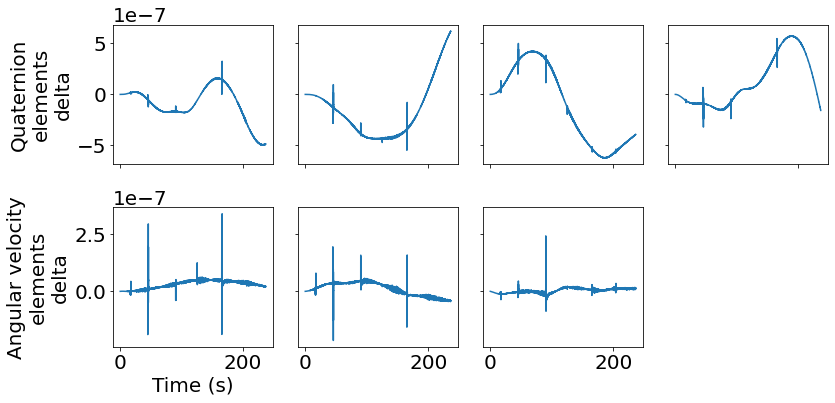

In [64]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey="row")
axs[0, 0].plot(time_s, estimates[:, 0] - srp_estimates[:, 0])
axs[0, 1].plot(time_s, estimates[:, 1] - srp_estimates[:, 1])
axs[0, 2].plot(time_s, estimates[:, 2] - srp_estimates[:, 2])
axs[0, 3].plot(time_s, estimates[:, 3] - srp_estimates[:, 3])
axs[1, 0].plot(time_s, estimates[:, 4] - srp_estimates[:, 4])
axs[1, 1].plot(time_s, estimates[:, 5] - srp_estimates[:, 5])
axs[1, 2].plot(time_s, estimates[:, 6] - srp_estimates[:, 6])
fig.delaxes(axs[1, 3])
axs[0, 0].set_ylabel("Quaternion\nelements\ndelta")
axs[1, 0].set_ylabel("Angular velocity\nelements\ndelta")
axs[1, 0].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

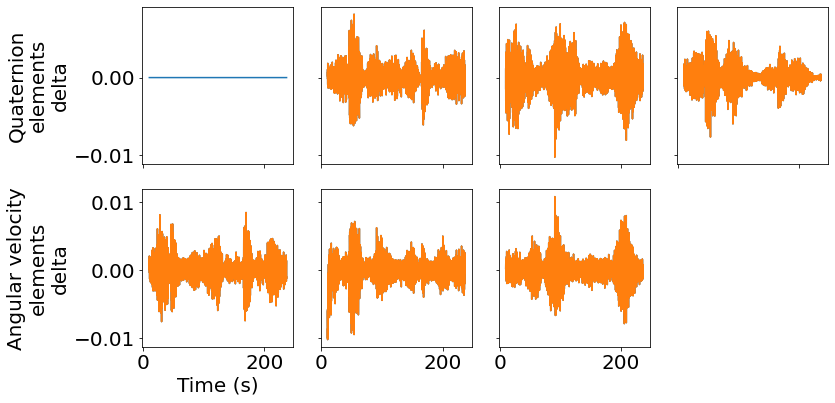

In [76]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey="row")
axs[0, 0].plot(time_s[200:], (estimates[200:, 0] - state_gt[200:, 0]) - (srp_estimates[200:, 0] - srp_state_gt[200:, 0]))
#axs[0, 0].plot(time_s[200:], srp_estimates[200:, 0] - srp_state_gt[200:, 0])
axs[0, 1].plot(time_s[200:], estimates[200:, 1] - state_gt[200:, 1])
axs[0, 1].plot(time_s[200:], srp_estimates[200:, 1] - srp_state_gt[200:, 1])
axs[0, 2].plot(time_s[200:], estimates[200:, 2] - state_gt[200:, 2])
axs[0, 2].plot(time_s[200:], srp_estimates[200:, 2] - srp_state_gt[200:, 2])
axs[0, 3].plot(time_s[200:], estimates[200:, 3] - state_gt[200:, 3])
axs[0, 3].plot(time_s[200:], srp_estimates[200:, 3] - srp_state_gt[200:, 3])
axs[1, 0].plot(time_s[200:], estimates[200:, 4] - state_gt[200:, 4])
axs[1, 0].plot(time_s[200:], srp_estimates[200:, 4] - srp_state_gt[200:, 4])
axs[1, 1].plot(time_s[200:], estimates[200:, 5] - state_gt[200:, 5])
axs[1, 1].plot(time_s[200:], srp_estimates[200:, 5] - srp_state_gt[200:, 5])
axs[1, 2].plot(time_s[200:], estimates[200:, 6] - state_gt[200:, 6])
axs[1, 2].plot(time_s[200:], srp_estimates[200:, 6] - srp_state_gt[200:, 6])
fig.delaxes(axs[1, 3])
axs[0, 0].set_ylabel("Quaternion\nelements\ndelta")
axs[1, 0].set_ylabel("Angular velocity\nelements\ndelta")
axs[1, 0].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()